# STM Transit Delay Data Preprocessing

## Overview

This notebook preprocesses data about STM trip updates weather and traffic, data in order to build a regression and classification model that predicts delays in seconds.

## Data Description

`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`route_type`: Type of bus line (e.g. Night).<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_name`: Name of the stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`stop_sequence`: Sequence of the stop, for ordering.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 (first stop) to 1 (last stop).<br>
`stop_has_alert`: Indicates if there's a message about the stop being moved or cancelled.<br>
`schedule_relationship`: State of the schedule: "scheduled", "skipped" or "no data".
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`rt_arrival_time`, `rt_departure_time`, `sch_arrival_time`, `sch_departure_time`: Realtime and scheduled times, in UTC.<br>
`delay`: Difference between real and scheduled arrival time, in seconds<br>
`delay_class`: Delay category, from early to late<br>
`incident_count`: Number of incidents within 500 meters of the stop.<br>
`incident_nearby`: Indicates if an incident happened within 500 meters of the stop.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`dew_point`: Dew point temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`wind_gusts`: Gusts at 10 meters above ground as a maximum of the preceding hour.<br>

## Imports

In [26]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import DELAY_CLASS, LOCAL_TIMEZONE, OCCUPANCY_STATUS

In [3]:
# Load data
df = pd.read_parquet('../data/stm_weather_traffic_merged.parquet')

## Data Preprocessing

### Handle Delay Outliers

In [4]:
df['delay'].describe()

count    1.430718e+06
mean     6.533164e+01
std      3.707634e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      1.200000e+01
max      5.458500e+04
Name: delay, dtype: float64

In [5]:
# Compute mean and standard deviation
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

In [6]:
# Filter outliers based on standard deviation
outlier_mask = (df['delay'] < mean_delay - 3 * std_delay) | (df['delay'] > mean_delay + 3 * std_delay)

In [7]:
# Get proportion of outliers
print(f'{outlier_mask.mean():.2%}')

0.72%


In [8]:
# Remove outliers
df = df[~outlier_mask].reset_index(drop=True)

In [9]:
# Get new distribution
df['delay'].describe()

count    1.420354e+06
mean     5.304297e+01
std      1.452116e+02
min     -1.043000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.177000e+03
Name: delay, dtype: float64

### Encode Datetime

In [10]:
# Convert scheduled arrival time
df['sch_arrival_time'] = pd.to_datetime(df['sch_arrival_time'], utc=True).dt.tz_convert(LOCAL_TIMEZONE)

In [ ]:
# Convert datetime to day and hour
df['day_of_week'] = df['sch_arrival_time'].dt.day_of_week
df['hour'] = df['sch_arrival_time'].dt.hour

In [12]:
# Convert hour to time of day
def time_of_day(hour):
  if 5 <= hour < 10:
    return 'morning'
  elif 10 <= hour < 15:
    return 'midday'
  elif 15 <= hour < 20:
    return 'evening'
  else:
    return 'night'

df['time_of_day'] = df['hour'].apply(time_of_day)

In [13]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['time_of_day'], drop_first=True, dtype='int64', prefix='time_of_day')
df = df.join(one_hot).drop('time_of_day', axis=1)

In [14]:
# Add boolean value is_weekend
weekend_mask = df['day_of_week'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [15]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

In [16]:
# Drop unneeded time-related columns
df = df.drop(['rt_arrival_time', 'rt_departure_time', 'sch_arrival_time', 'sch_departure_time', 'hour'], axis=1)

### Use Ordinal Encoding for delay_class and occupancy_status

In [17]:
delay_map = {value: key for (key, value) in DELAY_CLASS.items()}
df['delay_class'] = df['delay_class'].map(delay_map).astype('int64')
df['delay_class'].value_counts(normalize=True)

delay_class
1    0.864844
2    0.118891
0    0.016265
Name: proportion, dtype: float64

In [18]:
occ_map = {value: key for (key, value) in OCCUPANCY_STATUS.items()}
df['occupancy_status'] = df['occupancy_status'].map(occ_map)
df['occupancy_status'].value_counts(normalize=True)

occupancy_status
1    0.456422
2    0.315397
3    0.211590
5    0.015835
0    0.000757
Name: proportion, dtype: float64

### Use One Hot Encoding for route_type and schedule_relationship

In [19]:
df['route_type'].value_counts()

route_type
Day                         799072
Rush Hour High Frequency    363818
All Day High Frequency      228300
Night                        29164
Name: count, dtype: int64

In [20]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['route_type'], drop_first=True, dtype='int64', prefix='route_type')
df = df.join(one_hot).drop('route_type', axis=1)

In [21]:
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled    1407136
Skipped         7380
No Data         5838
Name: count, dtype: int64

In [22]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['schedule_relationship'], drop_first=True, dtype='int64', prefix='sch_rel')
df = df.join(one_hot).drop('schedule_relationship', axis=1)

### Use K-Means to group weather conditions

In [ ]:
# Separate weather columns
weather_cols = [
  	'temperature',
	'relative_humidity',
  	'dew_point',
  	'precipitation',
  	'pressure',
	'cloud_cover',
  	'windspeed',
  	'wind_direction',
  	'wind_gusts'
]

In [33]:
# Group unique combinations of weather attributes
weather_df = df[weather_cols].groupby(weather_cols).size().reset_index().drop(0, axis=1)

In [34]:
# Scale data
scaler = StandardScaler()
weather_df_scaled = scaler.fit_transform(weather_df)
weather_df_scaled = pd.DataFrame(data=weather_df_scaled, columns=scaler.get_feature_names_out())
weather_df_scaled.head()

,temperature,relative_humidity,dew_point,precipitation,pressure,cloud_cover,windspeed,wind_direction,wind_gusts
0,-2.289342,-0.015113,-1.967156,-0.279724,0.147991,-1.192837,0.414459,1.092414,0.584357
1,-2.251384,-0.077984,-2.003283,-0.279724,0.329418,-0.970715,0.731522,1.042279,0.786076
2,-2.213426,0.110628,-1.876840,-0.279724,-0.139269,-1.692611,0.681459,1.122495,0.862590
3,-2.080573,0.424982,-1.551702,-0.279724,1.055127,-0.193289,-0.887165,-1.404312,-0.792898
4,-2.023636,-0.140854,-1.840714,-0.279724,0.465489,-0.415411,0.898397,0.982117,1.064310


In [35]:
# Create models with different k values
models = []
for k in range(2, 31):
	kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
	kmeans.fit(weather_df_scaled)
	labels = kmeans.labels_
	models.append({
		'k': k,
		'ssd': kmeans.inertia_,
		'silhouette': silhouette_score(weather_df_scaled, labels, metric='euclidean'),
	})

models_df = pd.DataFrame(models).set_index('k')

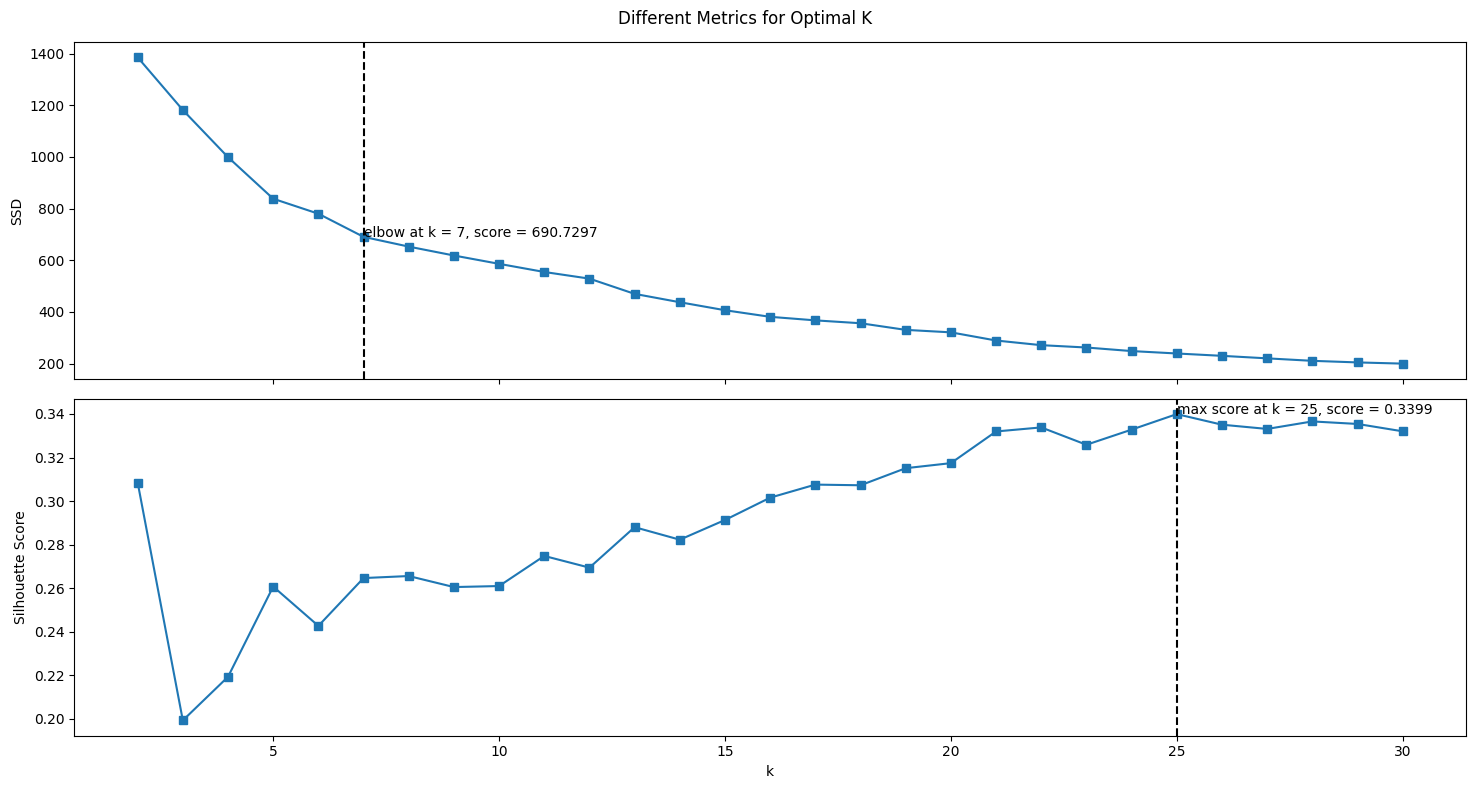

In [36]:
# Display k plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15,8), sharex=True)

# Elbow Method
kneedle = KneeLocator(models_df.index, models_df['ssd'], curve='convex', direction='decreasing')
optimal_k = kneedle.elbow
optimal_score = models_df.loc[optimal_k, 'ssd']
ax1.plot(models_df['ssd'], marker='s')
ax1.set_ylabel('SSD')
ax1.axvline(x=optimal_k, color='black', linestyle='--')
ax1.annotate(f'elbow at k = {optimal_k}, score = {round(optimal_score, 4)}', xy=(optimal_k, optimal_score))

# Silhouette Score
optimal_k = models_df['silhouette'].idxmax()
max_score = models_df['silhouette'].max()
ax2.plot(models_df['silhouette'], marker='s')
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette Score')
ax2.axvline(x=optimal_k, color='black', linestyle='--')
ax2.annotate(f'max score at k = {optimal_k}, score = {round(max_score, 4)}', xy=(optimal_k, max_score))

fig.suptitle(f'Different Metrics for Optimal K')
fig.tight_layout()
plt.show()

In [37]:
# Fit model with optimal k
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(weather_df_scaled)

KMeans(n_clusters=7, random_state=42)

In [ ]:
weather_df.insert(0, 'weather_group', kmeans.labels_)

In [41]:
weather_df.sort_values('weather_group')

,temperature,relative_humidity,dew_point,precipitation,pressure,cloud_cover,windspeed,wind_direction,wind_gusts,weather_group
61,10.0,85,7.6,0.5,1010.1,100,11.2,120,26.3,0
63,10.1,66,4.1,0.9,1012.4,100,10.5,66,25.6,0
58,9.9,92,8.6,2.1,1006.0,100,16.5,158,45.7,0
49,9.5,80,6.2,0.6,1010.6,100,13.0,96,27.7,0
59,9.9,93,8.9,4.0,1005.8,100,15.3,155,42.8,0
...,...,...,...,...,...,...,...,...,...,...
141,15.6,48,4.6,0.0,1018.3,99,7.2,162,11.5,6
137,15.2,39,1.2,0.0,1017.8,100,3.5,81,15.5,6
129,14.6,55,5.7,0.0,1018.9,91,5.0,21,5.0,6
148,16.1,57,7.5,0.0,1016.5,98,2.9,7,5.8,6


In [42]:
# Merge weather clusters to main dataframe
df = pd.merge(left=df, right=weather_df, how='inner', on=weather_cols)

In [43]:
df.columns

Index(['trip_id', 'vehicle_id', 'vehicle_bearing', 'vehicle_speed',
       'vehicle_in_transit', 'occupancy_status', 'route_id', 'stop_id',
       'stop_name', 'stop_lat', 'stop_lon', 'stop_distance', 'stop_sequence',
       'trip_progress', 'stop_has_alert', 'wheelchair_boarding', 'delay',
       'delay_class', 'incident_count', 'incident_nearby', 'temperature',
       'relative_humidity', 'dew_point', 'precipitation', 'pressure',
       'cloud_cover', 'windspeed', 'wind_direction', 'wind_gusts', 'month',
       'day_of_week', 'time_of_day_midday', 'time_of_day_morning',
       'time_of_day_night', 'is_weekend', 'is_peak_hour', 'route_type_Day',
       'route_type_Night', 'route_type_Rush Hour High Frequency',
       'sch_rel_Scheduled', 'sch_rel_Skipped', 'weather_group'],
      dtype='object')

In [44]:
df.head()

,trip_id,vehicle_id,vehicle_bearing,vehicle_speed,vehicle_in_transit,occupancy_status,route_id,stop_id,stop_name,stop_lat,...,time_of_day_morning,time_of_day_night,is_weekend,is_peak_hour,route_type_Day,route_type_Night,route_type_Rush Hour High Frequency,sch_rel_Scheduled,sch_rel_Skipped,weather_group
0,284214231,33839,0.0,0.0,0,2,80,51798,du Parc / Villeneuve,45.518121,...,0,0,1,0,0,0,1,1,0,5
1,284214231,33839,0.0,0.0,1,1,80,54225,Aréna Howie-Morenz,45.534367,...,0,0,1,0,0,0,1,1,0,5
2,283855472,32018,54.0,0.0,1,1,49,60515,Perras / 81e Avenue,45.668193,...,0,0,1,0,0,0,1,1,0,5
3,283213434,40187,0.0,0.0,0,1,968,60296,Station Côte-Vertu,45.514212,...,0,0,1,0,1,0,0,1,0,5
4,283213434,40187,0.0,0.0,1,1,968,61988,Gare Roxboro-Pierrefonds,45.510414,...,0,0,1,0,1,0,0,1,0,5


### Drop redundant/unnecessary columns


In [45]:
# Get remaining string columns
df.select_dtypes(include='object').columns

Index(['stop_name'], dtype='object')

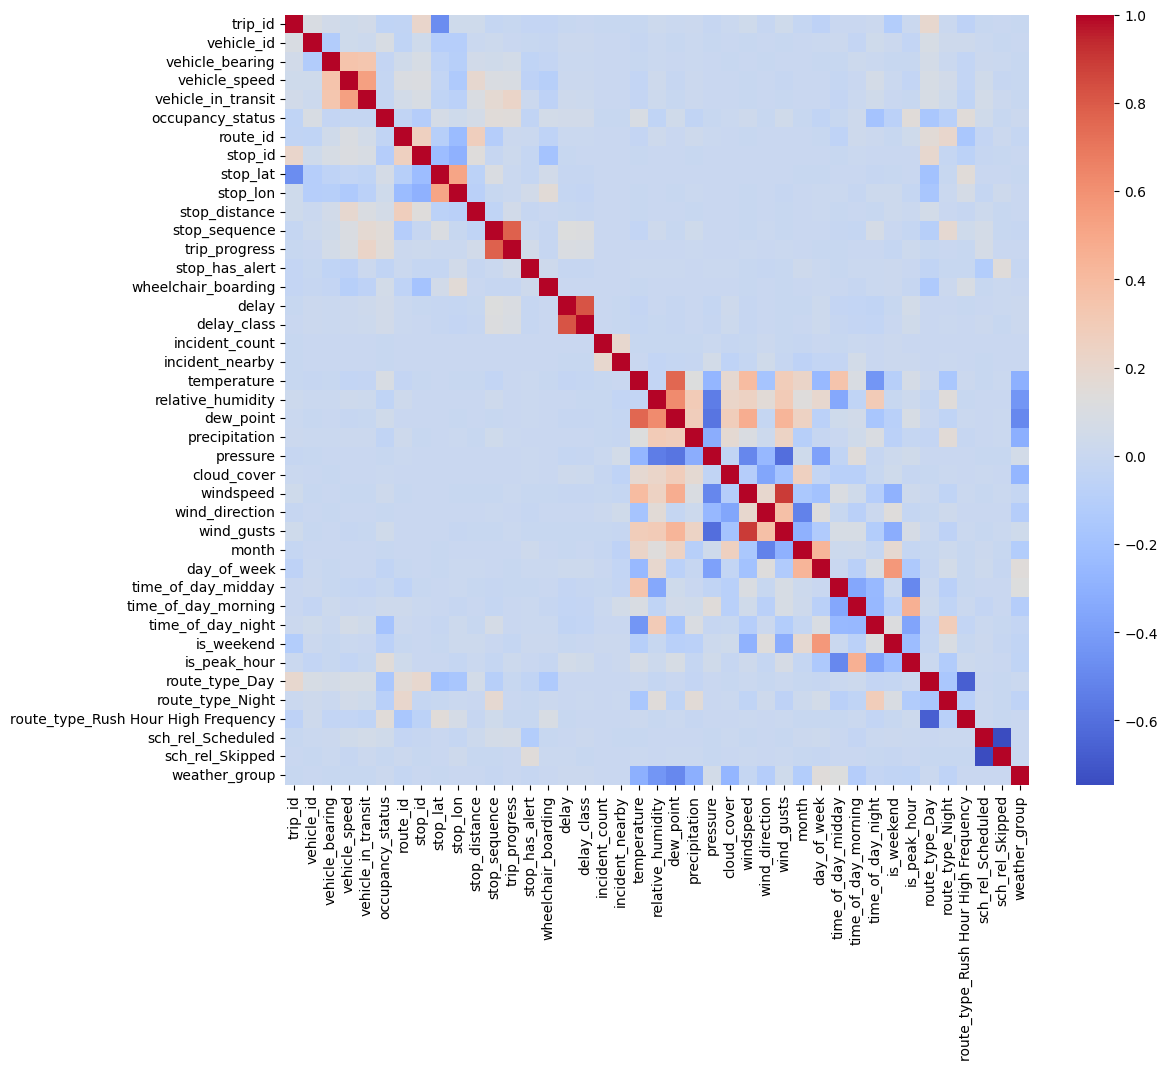

In [46]:
# Check for highly correlated features
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

**Columns to drop**

`trip_id`: Identifies a vehicle on a specific day and might cause data leakage.<br>
`vehicle_id`: A unique identifuer of a vehicle won't help to make predictions.<br>
`route_id`: The route types have been encoded.<br>
`stop_id`, `stop_name`: The stop is already encoded with the coordinates.<br>
`stop_sequence`: The trip progress has been calculated.<br>
`temperature`, `relative_humidity`, `dew_point`, `precipitation`, `pressure`, `cloud_cover`, `windspeed`, `wind_direction`, `wind_gusts`: The weather attributes have been grouped.<br>


In [48]:
df = df.drop([
  	'trip_id',
  	'vehicle_id',
  	'route_id',
  	'stop_id',
  	'stop_name',
  	'stop_sequence',
  	'temperature',
	'relative_humidity',
  	'dew_point',
  	'precipitation',
  	'pressure',
	'cloud_cover',
  	'windspeed',
  	'wind_direction',
  	'wind_gusts'
  ], axis=1)

## Export Data

In [49]:
df.columns

Index(['vehicle_bearing', 'vehicle_speed', 'vehicle_in_transit',
       'occupancy_status', 'stop_lat', 'stop_lon', 'stop_distance',
       'trip_progress', 'stop_has_alert', 'wheelchair_boarding', 'delay',
       'delay_class', 'incident_count', 'incident_nearby', 'month',
       'day_of_week', 'time_of_day_midday', 'time_of_day_morning',
       'time_of_day_night', 'is_weekend', 'is_peak_hour', 'route_type_Day',
       'route_type_Night', 'route_type_Rush Hour High Frequency',
       'sch_rel_Scheduled', 'sch_rel_Skipped', 'weather_group'],
      dtype='object')

In [ ]:
# Reorder columns
df = df[[
    	'vehicle_bearing',
    	'vehicle_speed',
    	'vehicle_in_transit',
       	'occupancy_status',
        'route_type_Day',
       	'route_type_Night',
    	'route_type_Rush Hour High Frequency',
		'stop_lat',
		'stop_lon',
		'stop_distance',
		'trip_progress',
    	'stop_has_alert',
      	'wheelchair_boarding',
		'sch_rel_Scheduled',
       	'sch_rel_Skipped',
		'day_of_week',
    	'time_of_day_midday',
    	'time_of_day_morning',
       	'time_of_day_night',
    	'is_weekend',
       	'is_peak_hour',
		'incident_count',
		'incident_nearby',
		'weather_group',
    	'delay',
       	'delay_class',
]]

KeyError: "['time_of_day_nightis_weekend'] not in index"

In [ ]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [ ]:
# Export scaler
with open('../models/weather_scaler.pkl', 'wb') as handle:
	pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Export dataframe
df.to_parquet('../data/preprocessed.parquet', index=False)

## End